# Rectification in a spin chain

-------

We consider a one-dimensional lattice of spinless fermions in a tilted potential, given by the Hamiltonian

$$ H = \sum_{j=1}^{N-1} \Big[ \frac{J}{2} (c_j^\dagger c_{j+1}  + h.c.) + \Delta \Big( n_j - \frac{1}{2} \Big)\Big( n_{j+1} - \frac{1}{2} \Big) \Big] + \sum_{j=1}^{N} \Big( \mu + \frac{j E}{2} \Big) \Big( n_j - \frac{1}{2} \Big) \; ,$$

where $N$ is the number of lattice sites, $J$ is the hopping amplitude, $\Delta$ is the nearest-neighbour density-density interaction, $\mu$ is the chemical potential and $E$ is the strength of the tilting. The purpose is to use it as a diode.

We can simulate the dynamics of the system using the `qutip.mesolve` function, which returns the states at each given time step. The most general type of evolution (under certain approximations) is given by 

$$ \frac{d\rho}{dt} = -i [H,\rho] + \sum_k \mathcal{L}_k(\rho) \; , $$

where the Lindblad generator is given by

$$ \mathcal{L}_k(\rho) = L_k \rho L^{\dagger}_k - \frac{1}{2} \{ L^{\dagger}_k L_k, \rho \} \; . $$

For this problem, we define the jump operators of the dissipative process acting on the boundaries of the chain

$$ L^{+}_{1,N} = \sqrt{\Gamma(1\pm f)/8} c_{1,N}^\dagger \; , $$ $$ L^{-}_{1,N} = \sqrt{\Gamma(1\mp f)/8} c_{1,N} \; , $$

where $\Gamma$ is the coupling strength and the driving parameter $-1 \leq f \leq 1$ established the bias. Namely, $f > 0$ particles are created in site $1$ and annihilated in site $N$ giving rise to forward driving and vice-versa. Moreover, we also study dephasing, implemented by the operator $ L^{\mathrm{deph}}_{i} = \chi c_{i}^\dagger c_{i} $ at each site.

-----
## 1) Setup

In [1]:
# IMPORTS

import matplotlib.pyplot as plt
import numpy as np
from qutip import*
%matplotlib inline

### 1.1) Operator basis

In [2]:
def create_list(N):
    
    create_list = []
    for i in range(N):
        op_list = [qeye(2)] * N
        op_list[i] = create(2)
        create_list.append(tensor(op_list))
        
    return create_list

def destroy_list(N):
    
    destroy_list = []
    for i in range(N):
        op_list = [qeye(2)] * N
        op_list[i] = destroy(2)
        destroy_list.append(tensor(op_list))
        
    return destroy_list


def number_list(N):
    
    number_list = []
    for i in range(N):
        op_list = [qeye(2)] * N
        op_list[i] = num(2)
        number_list.append(tensor(op_list))
        
    return number_list

### 1.2) Hamiltonian

In [3]:
def Hamiltonian(N, Δ, E):
    
    ''' Builds the Hamiltonian from creation, annihilation and number operators. '''
    
    H = 0
    
    # Kinetic energy and nearest-neighbour interaction
    for i in range(N-1):
        H += (J/2) * ((create_list(N)[i] * destroy_list(N)[i+1]) + (create_list(N)[i] * destroy_list(N)[i+1]).dag())
        H += Δ * ((number_list(N)[i] - 0.5 * tensor([qeye(2)]*N)) * (number_list(N)[i+1] - 0.5 * tensor([qeye(2)]*N)))
    
    # Tilted potential
    for i in range(N):
        H += ((μ + i * E/2) * tensor([qeye(2)]*N)) * (number_list(N)[i] - 0.5 * tensor([qeye(2)]*N))   
        
    return H

### 1.3) Local current

One important observable to compute is the particle current:

$$ \mathcal{J}_j = \frac{i J}{2} ( c^{\dagger}_j c_{j+1} - c^{\dagger}_{j+1} c_{j} ) \; , $$

for $j = 1,2,... N-1$. At steady-state the current is homogeneous throughout the chain $\langle \mathcal{J}_i \rangle = \mathcal{J}_{\mathrm{ss}}$.

In [4]:
def current(N):

    current_list = []
    for i in range(N-1):
        current_list.append(0.5j*J*(create_list(N)[i] * destroy_list(N)[i+1] - create_list(N)[i+1] * destroy_list(N)[i]))
    return current_list

### 1.4) Dissipator

In [5]:
def dissipator(N, χ, bias = 'f', Γ = 1):
    
    ''' Defines dissipators at the boundary of the chain, either with forward (f) or reverse (r) bias. '''

    if bias == 'r':
        f = -1
        c_ops = [np.sqrt(Γ*(1-f)/8) * create_list(N)[N-1], np.sqrt(Γ*(1-f)/8) * destroy_list(N)[0]]
    else:
        f = 1
        c_ops = [np.sqrt(Γ*(1+f)/8) * create_list(N)[0], np.sqrt(Γ*(1+f)/8) * destroy_list(N)[N-1]]
    for i in range(N):
        c_ops.append(χ * number_list(N)[i])
    
    return c_ops

-------
## 2) Results

In [6]:
# PARAMETERS

N = 8
J = 1
Δ = 5
E = 3.67
μ = - E*(N+1)/4

### 2.1) Steady-state

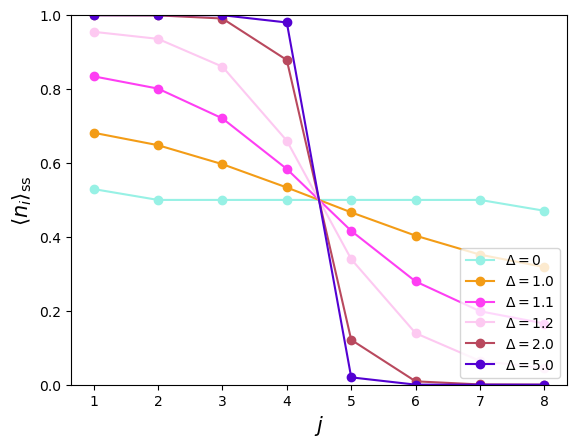

In [7]:
# PARTICLE DISTRIBUTION AS A FUNCTION OF INTERACTION Δ

Δ_list = [0, 1.0, 1.1, 1.2, 2.0, 5.0]
sites = [l+1 for l in range(N)]

for i in range(len(Δ_list)):    
    rhoss = steadystate(Hamiltonian(N, Δ_list[i], 0), dissipator(N, 0, 'f'), method = 'eigen')
    colors = (np.random.random(), np.random.random(), np.random.random())
    plt.plot(sites, expect(number_list(N),rhoss),label = r"$ \Delta = {}$".format(Δ_list[i]), linestyle = 'solid', marker='o', c = colors)
    plt.legend(loc = "lower right", fontsize = 10);
    
plt.xticks([i+1 for i in range(N)])
plt.ylim(0,1)
plt.ylabel(r"$\langle n_i \rangle_{\mathrm{ss}}$", fontsize = 15);
plt.xlabel(r"$j$", fontsize = 15);

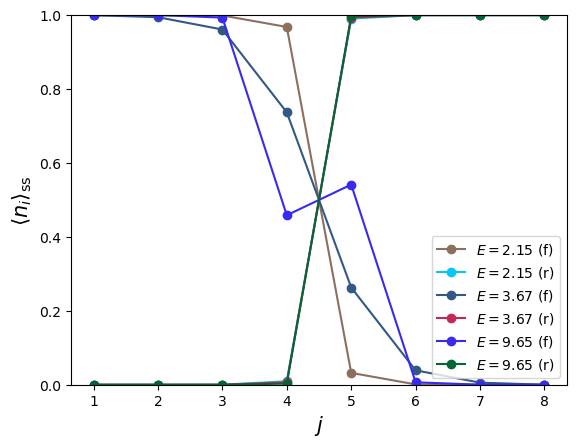

In [8]:
# PARTICLE DISTRIBUTION AS A FUNCTION OF TILTING E

E_list = [2.15, 3.67, 9.65]
bias = ['f','r']

for i in range(len(E_list)):
    for j in range(len(bias)):
        rhoss = steadystate(Hamiltonian(N, 5, E_list[i]), dissipator(N, 0, bias[j]), method = 'eigen')
        colors = (np.random.random(), np.random.random(), np.random.random())
        plt.plot(sites, expect(number_list(N), rhoss), label = r"$ E = {}$ ({})".format(E_list[i], bias[j]), linestyle ='solid', marker = 'o', c = colors)
        plt.legend(loc = "lower right", fontsize = 10);
    
plt.xticks([i+1 for i in range(N)])
plt.ylim(0,1)
plt.ylabel(r"$\langle n_i \rangle_{\mathrm{ss}}$", fontsize = 15);
plt.xlabel(r"$j$", fontsize = 15);

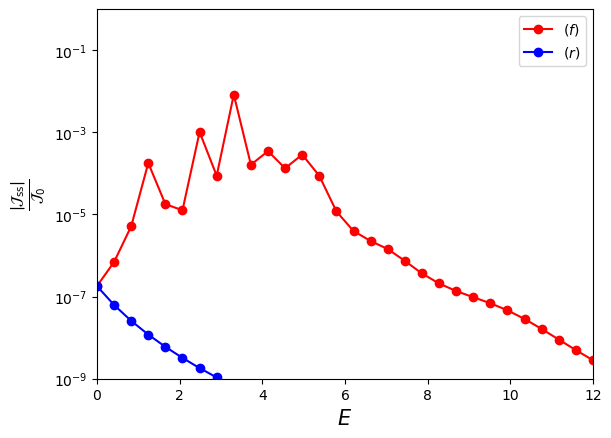

In [9]:
# STEADY-STATE CURRENT AS A FUNCTION OF TILTING E

E_list = np.linspace(0, 12, 30)

currentssf = []
currentssr = []

for i in range(len(E_list)):    
    
    rhoss = steadystate(Hamiltonian(N, 5, E_list[i]), dissipator(N, 0, 'f'), method = 'eigen')
    currentssf.append(expect(current(N)[0], rhoss))
    rhoss = steadystate(Hamiltonian(N, 5, E_list[i]), dissipator(N, 0, 'r'), method = 'eigen')
    currentssr.append(expect(current(N)[0], rhoss))

rhoss_0 = steadystate(Hamiltonian(N, 0, 0), dissipator(N, 0, 'f'), method = 'eigen')
currentss0 = expect(current(N)[0], rhoss_0)
currentssf_norm = np.array(np.absolute(currentssf))/currentss0
currentssr_norm = np.array(np.absolute(currentssr))/currentss0

plt.plot(E_list, currentssf_norm, label = r"$(f)$", linestyle = 'solid', marker = 'o', c = 'red')
plt.plot(E_list, currentssr_norm, label = r"$(r)$", linestyle = 'solid', marker = 'o', c = 'blue')
plt.legend(loc = "upper right", fontsize = 10);
plt.ylabel(r"$ \frac{ | \mathcal{J}_{\mathrm{ss}} |}{\mathcal{J}_0}$", fontsize = 15);
plt.yscale('log')
plt.ylim(10**-9, 10**0)
plt.xlim(E_list[0], E_list[-1])
plt.xlabel(r"$E$", fontsize = 15);

/tmp/ipykernel_37382/874012485.py:3: RuntimeWarning: divide by zero encountered in true_divide
  rectification = currentssf_norm/currentssr_norm


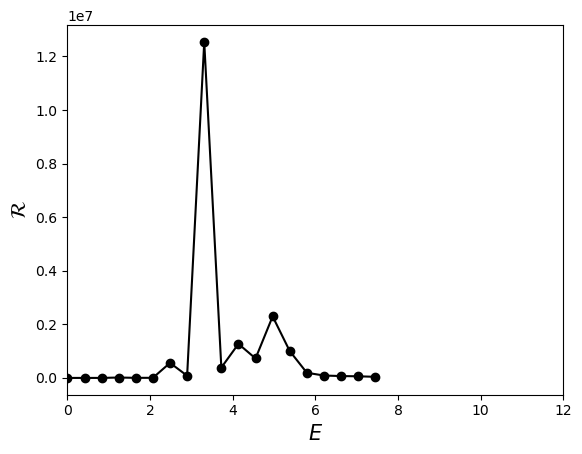

In [10]:
# RECTIFICATION AS A FUNCTION OF TILTING E

rectification = currentssf_norm/currentssr_norm

plt.plot(E_list, rectification, linestyle = 'solid', marker = 'o', c = 'black')
plt.ylabel(r"$ \mathcal{R} $", fontsize = 15);
plt.xlim(E_list[0],E_list[-1])
plt.xlabel(r"$E$", fontsize = 15);

In [ ]:
# STEADY-STATE CURRENT VS. DEPHASING

E_list = [0, 0.05, 0.2, 0.5, 1, 1.5]
χ_list = np.linspace(0, 5, 30)

for i in range(len(E_list)):
    currentss_list_χ = []
    for j in range(len(χ_list)):
        rhoss = steadystate(Hamiltonian(N, 0, E_list[i]), dissipator(N, χ_list[j], 'f'), method = 'eigen')
        currentss = expect(current(N)[0],rhoss)
        currentss_norm = np.array(np.absolute(currentss))/currentss0
        currentss_list_χ.append(currentss_norm)
    colors = (np.random.random(), np.random.random(), np.random.random())
    plt.plot(χ_list, currentss_list_χ, label = r"$ E = {}$".format(E_list[i]), linestyle = 'solid', marker = 'o', c = colors)    
    
plt.legend(loc = "upper right", fontsize = 10)
plt.ylabel(r"$ \frac{ | \mathcal{J}_{\mathrm{ss}} |}{\mathcal{J}_0}$", fontsize = 15)
plt.xlabel("Dephasing", fontsize = 15)
plt.xlim(χ_list[0],χ_list[-1]);

### 2.2) Dynamics

In [ ]:
# INITIAL STATE

rho0 = tensor([fock_dm(2,1)] + [fock_dm(2,0)]*(N-1))
#print(rho0)

# TIME EVOLUTION

H = Hamiltonian(N, Δ, E)

times = np.linspace(0, 200, 500)
result = mesolve(H, rho0, times, dissipator(N, 0, 'f'), [])
rhot = [rho for rho in result.states]

In [ ]:
# PLOT CURRENTS OVER TIME

for i in range(N-1):
    plt.plot(times, expect(current(N)[i],rhot), label = r"$ \langle J_{}(t) \rangle $".format(i+1))
    
plt.xlabel("Time", fontsize = 15)
plt.legend(loc = "lower right", fontsize = 15);

In [ ]:
# PLOT NUMBER OF PARTICLES OVER TIME

for i in range(N):
    plt.plot(times, expect(number_list(N)[i],rhot), label = r"$\langle n_{}(t) \rangle$".format(i+1))
    
plt.xlabel("Time", fontsize = 15)
plt.ylabel("Particle number", fontsize = 15)
plt.legend(loc = "lower right",fontsize = 15);